In [2]:
#import necessary python libraries
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize
import pandas as pd
import math
from JSON_to_DF import JSON_to_DataFrame
from Lightcurve_class import *
import celerite
import pickle
%matplotlib notebook

# Supernovae SN2011fe 

In [52]:
#create new supernovae object and load meta and Lightcurve data
SN2011fe = deserialize("../../../OSC_data/pickled_data/SN2011fe.pickle")
SN2011fe.Lightcurves


{'B_10': <Lightcurve_class.filter_lightcurve at 0x11c037630>,
 'B_13': <Lightcurve_class.filter_lightcurve at 0x11ac2c7f0>,
 'B_14,32': <Lightcurve_class.filter_lightcurve at 0x11ab3d080>,
 'B_20,32': <Lightcurve_class.filter_lightcurve at 0x11a188898>,
 'H_1': <Lightcurve_class.filter_lightcurve at 0x11a16bc50>,
 'I_14,32': <Lightcurve_class.filter_lightcurve at 0x11ab36e10>,
 'I_20,32': <Lightcurve_class.filter_lightcurve at 0x11a192630>,
 'Ic_13': <Lightcurve_class.filter_lightcurve at 0x11a16b588>,
 'J_1': <Lightcurve_class.filter_lightcurve at 0x11a0e7358>,
 'K_1': <Lightcurve_class.filter_lightcurve at 0x11a163208>,
 'M2_10': <Lightcurve_class.filter_lightcurve at 0x11a191ac8>,
 'R_14,32': <Lightcurve_class.filter_lightcurve at 0x11ac37860>,
 'R_20,32': <Lightcurve_class.filter_lightcurve at 0x11a1836a0>,
 'Rc_13': <Lightcurve_class.filter_lightcurve at 0x11aba2048>,
 'U_10': <Lightcurve_class.filter_lightcurve at 0x11b60b978>,
 'U_14,32': <Lightcurve_class.filter_lightcurve at 0

In [50]:


#Create Kernels for Gaussian Process

#Real term parameter initialization
a = 1e-5
c = 1
#Matern term parameter initialization
sig = 1e-5
rho = 100

#Bounds on parameters 
bounds = dict(log_a = (-15,15), log_c = (-15,15))
bounds = dict(log_sigma = (-15, 15), log_rho = (-15, 15))

#Create Kernels
Real_Kernel = celerite.terms.RealTerm(log_a = np.log(a), log_c = np.log(c), bounds=bounds)
Matern_Kernel = celerite.terms.Matern32Term(log_sigma = np.log(sig), log_rho = np.log(rho))



<IPython.core.display.Javascript object>


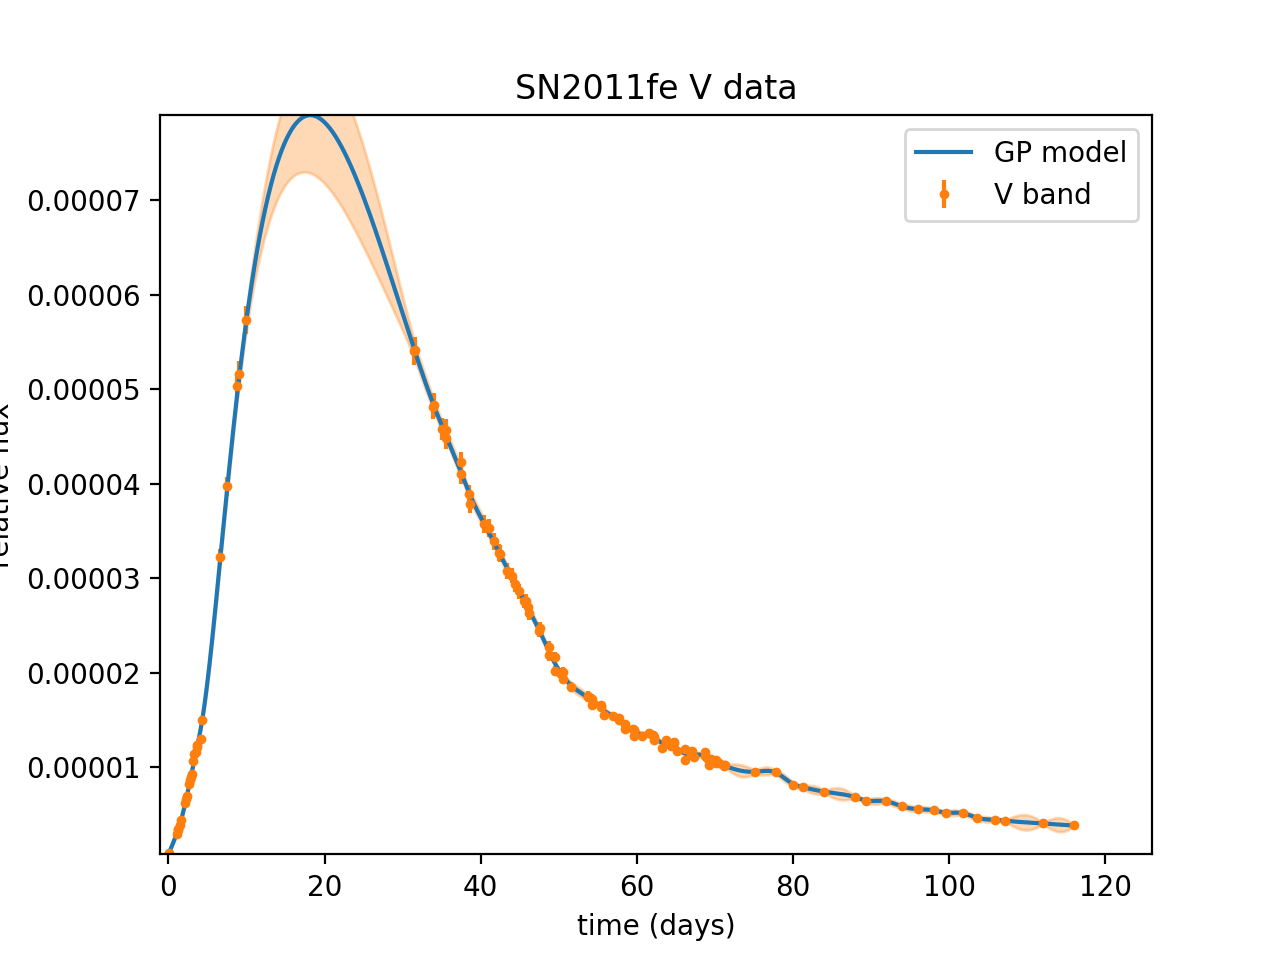

1.2450777915372038

In [53]:
#Matern_Kernel fit
plt.figure()
SN2011fe.Lightcurves['V_10'].Gaussian_process(Matern_Kernel)


<IPython.core.display.Javascript object>


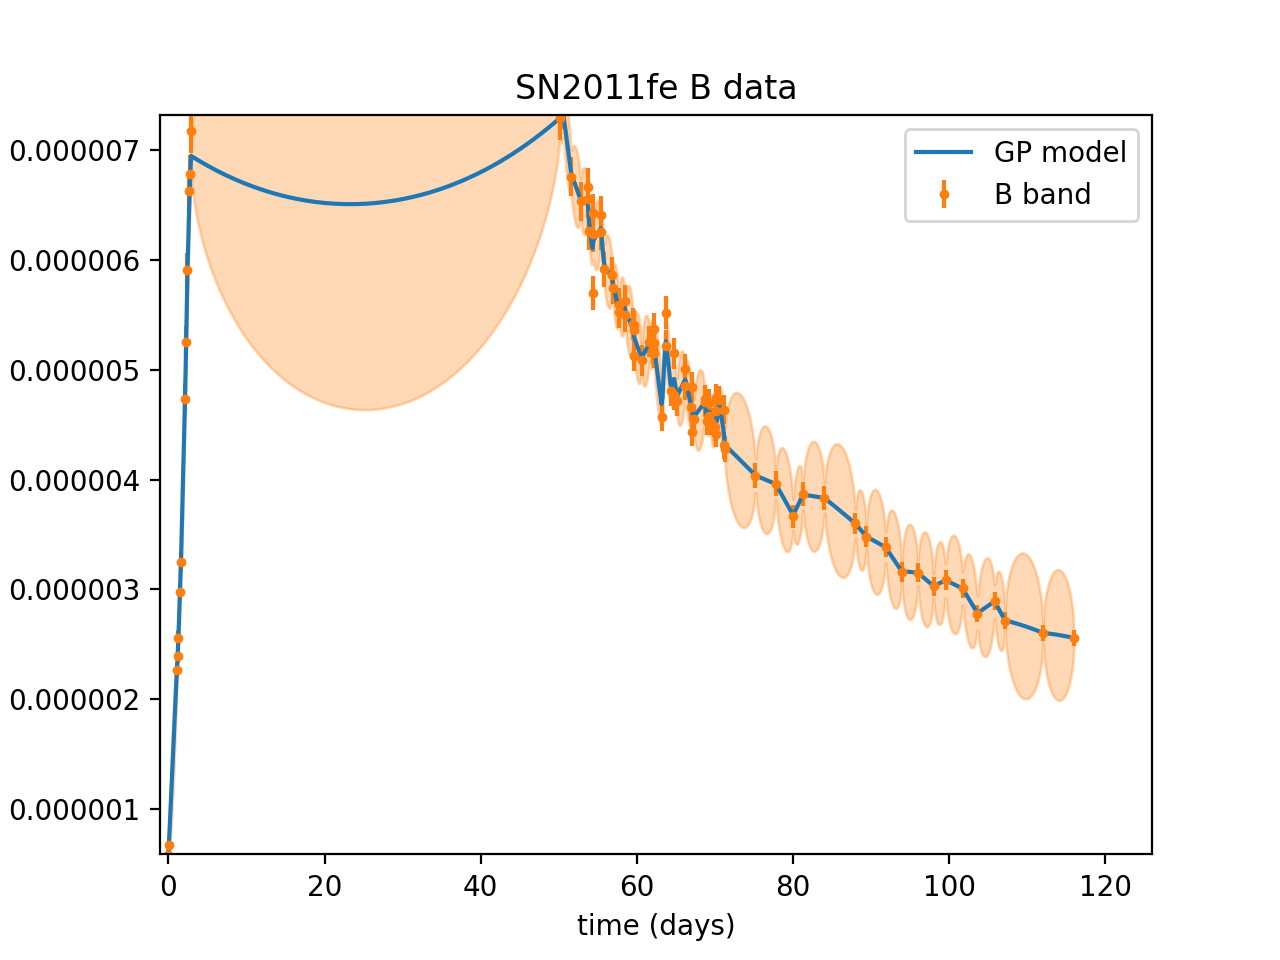

1.6300974341157113

In [54]:
plt.figure()
SN2011fe.Lightcurves['B_10'].Gaussian_process(Real_Kernel)

<IPython.core.display.Javascript object>


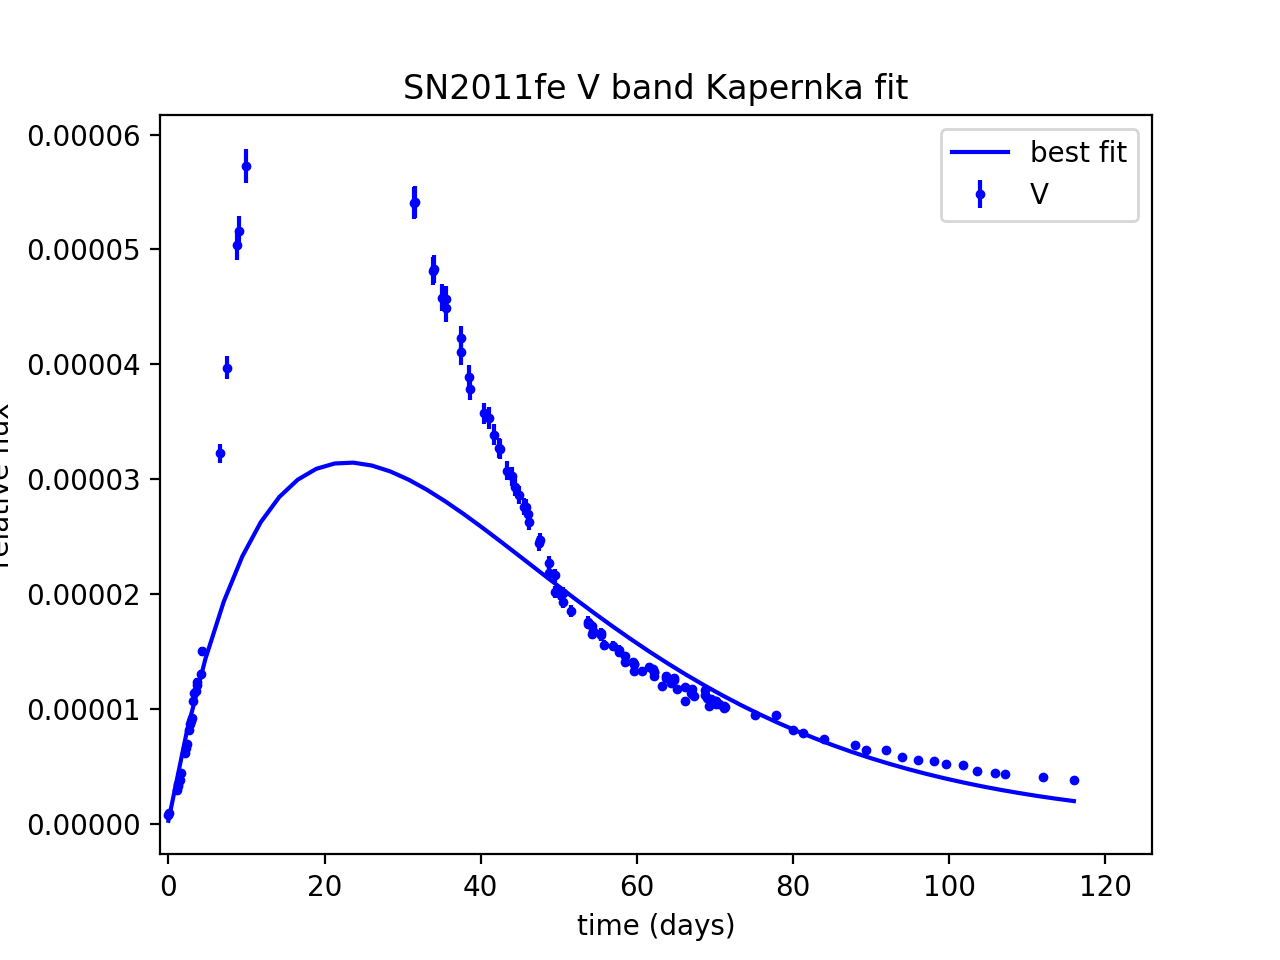

8.4052962691613136

In [56]:
plt.figure()
SN2011fe.Lightcurves['V_10'].Kapernka_fit_plot(plot=True)

<IPython.core.display.Javascript object>


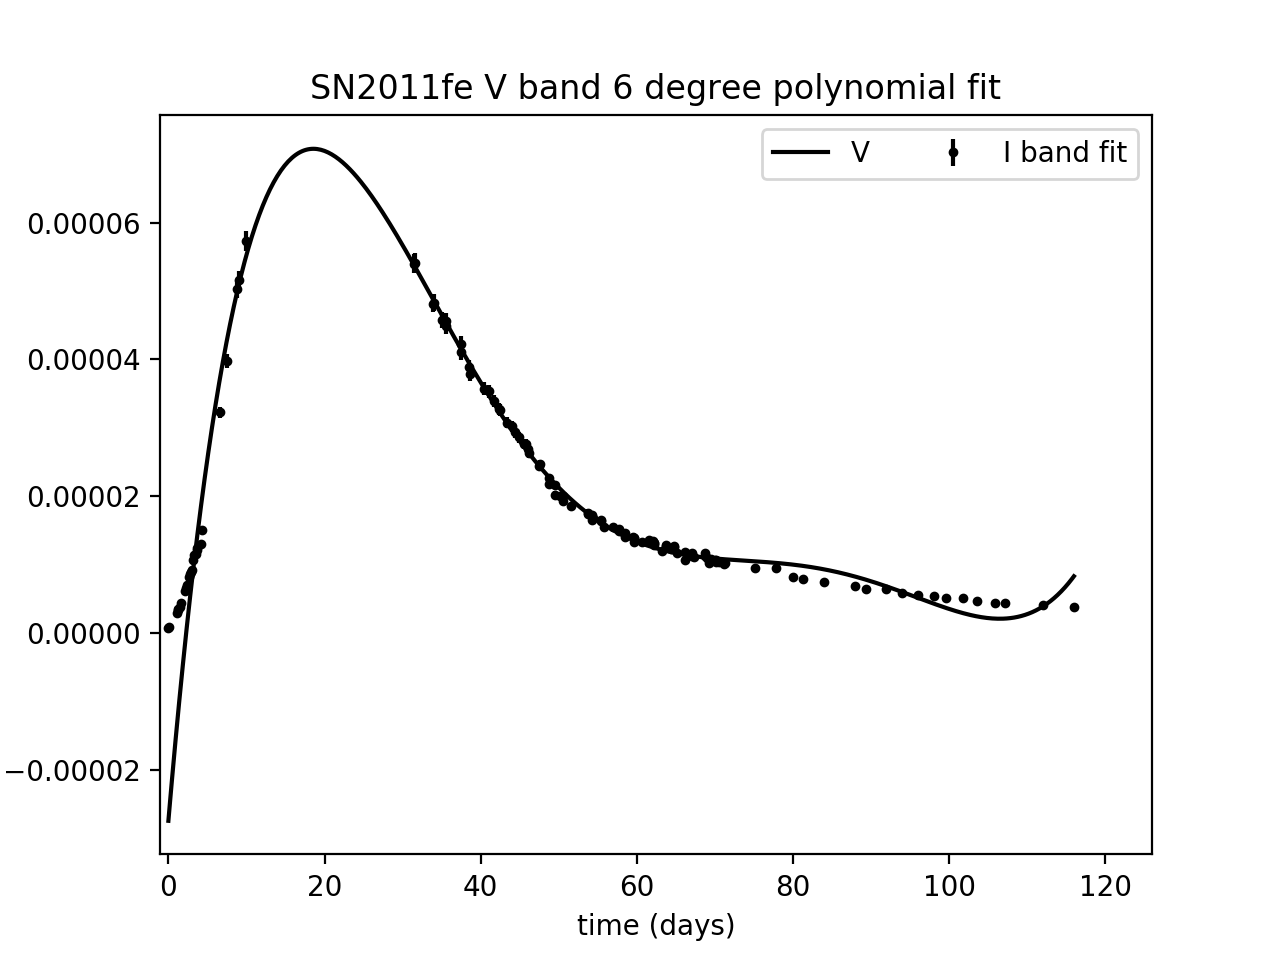

80.376483492032946

In [7]:
plt.figure()
SN2011fe.Lightcurves['V_9'].polynomial_fit_plot(6, plot=True)

<IPython.core.display.Javascript object>


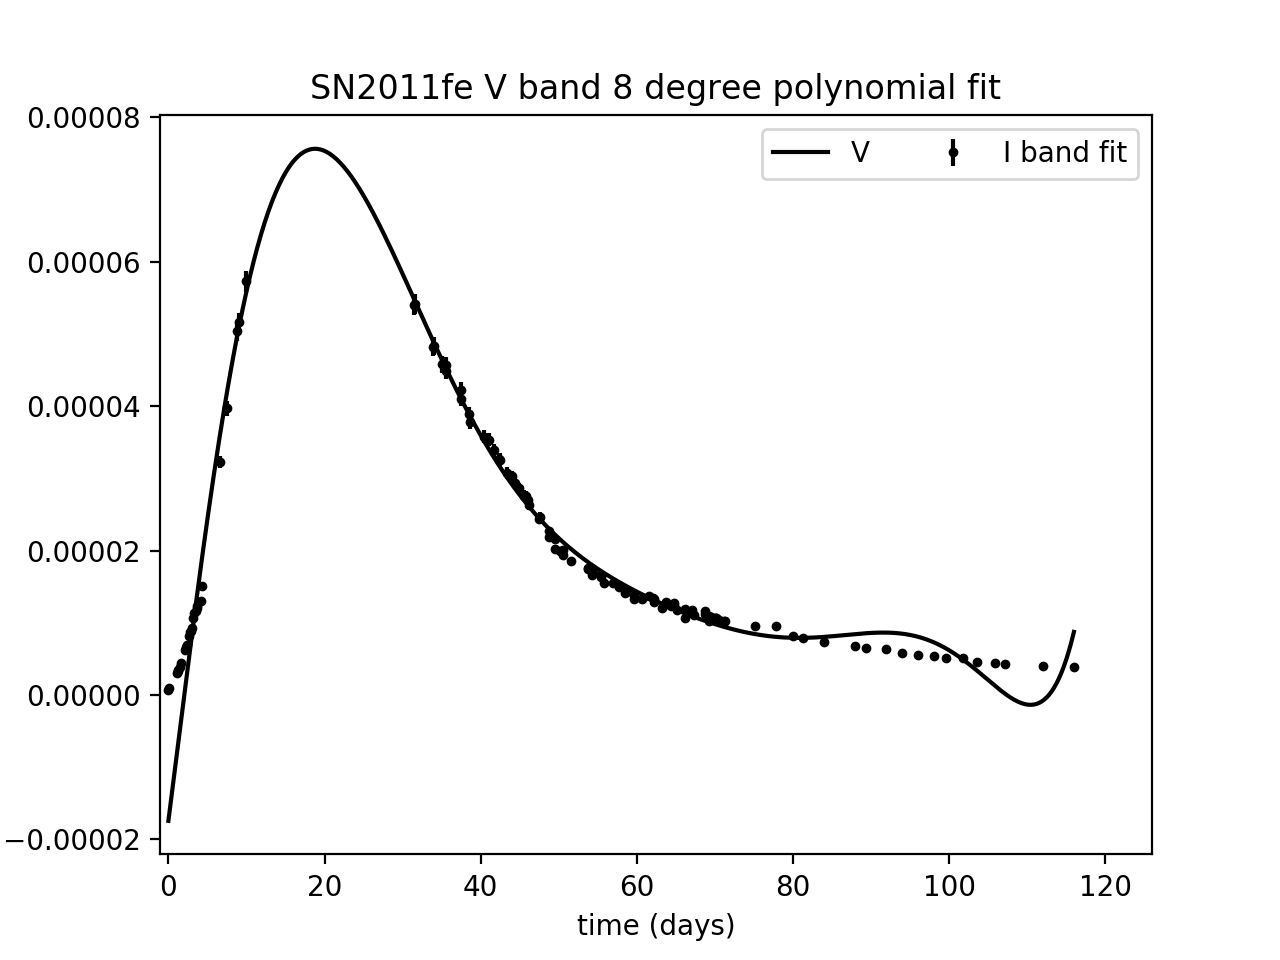

59.358258660495324

In [8]:
plt.figure()
SN2011fe.Lightcurves['V_9'].polynomial_fit_plot(8, plot=True)

<IPython.core.display.Javascript object>


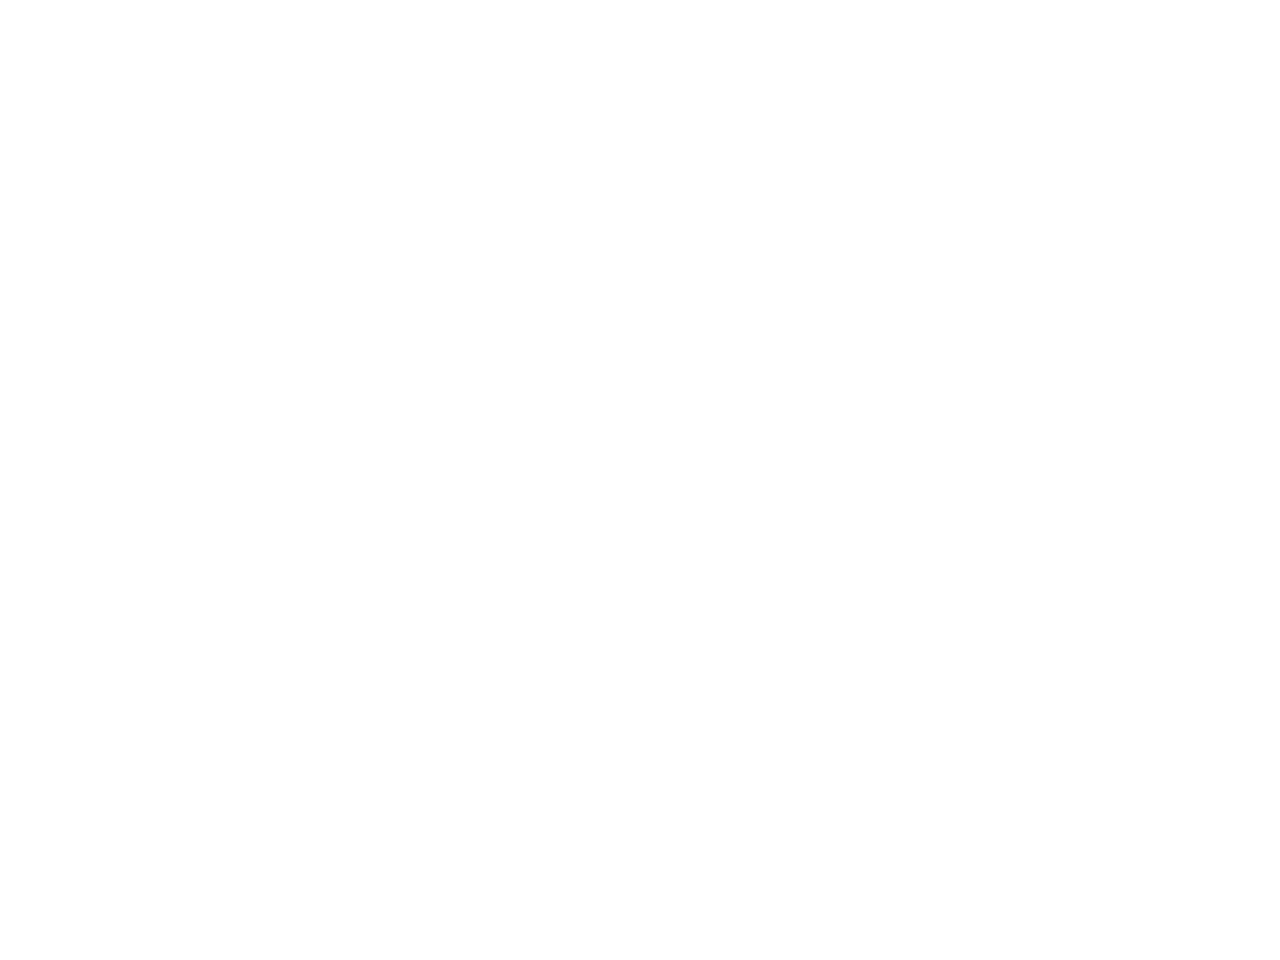

KeyError: 'V_9'

In [57]:
plt.figure()
SN2011fe.Lightcurves['V_9'].Bazin_fit_plot(plot=True)

In [10]:
SN2011fe.Lightcurves['V_9'].Rchi2

{'Bazin': 8.2476021464714364,
 'GP': 1.4071370974965141,
 'Kapernka': 8.4052962691613136,
 'polynomial_6': 80.376483492032946,
 'polynomial_8': 59.358258660495324}

# Supernovae SN2008es


In [58]:
SN2008es = deserialize("../../../OSC_data/pickled_data/SN2008es.pickle")

<IPython.core.display.Javascript object>


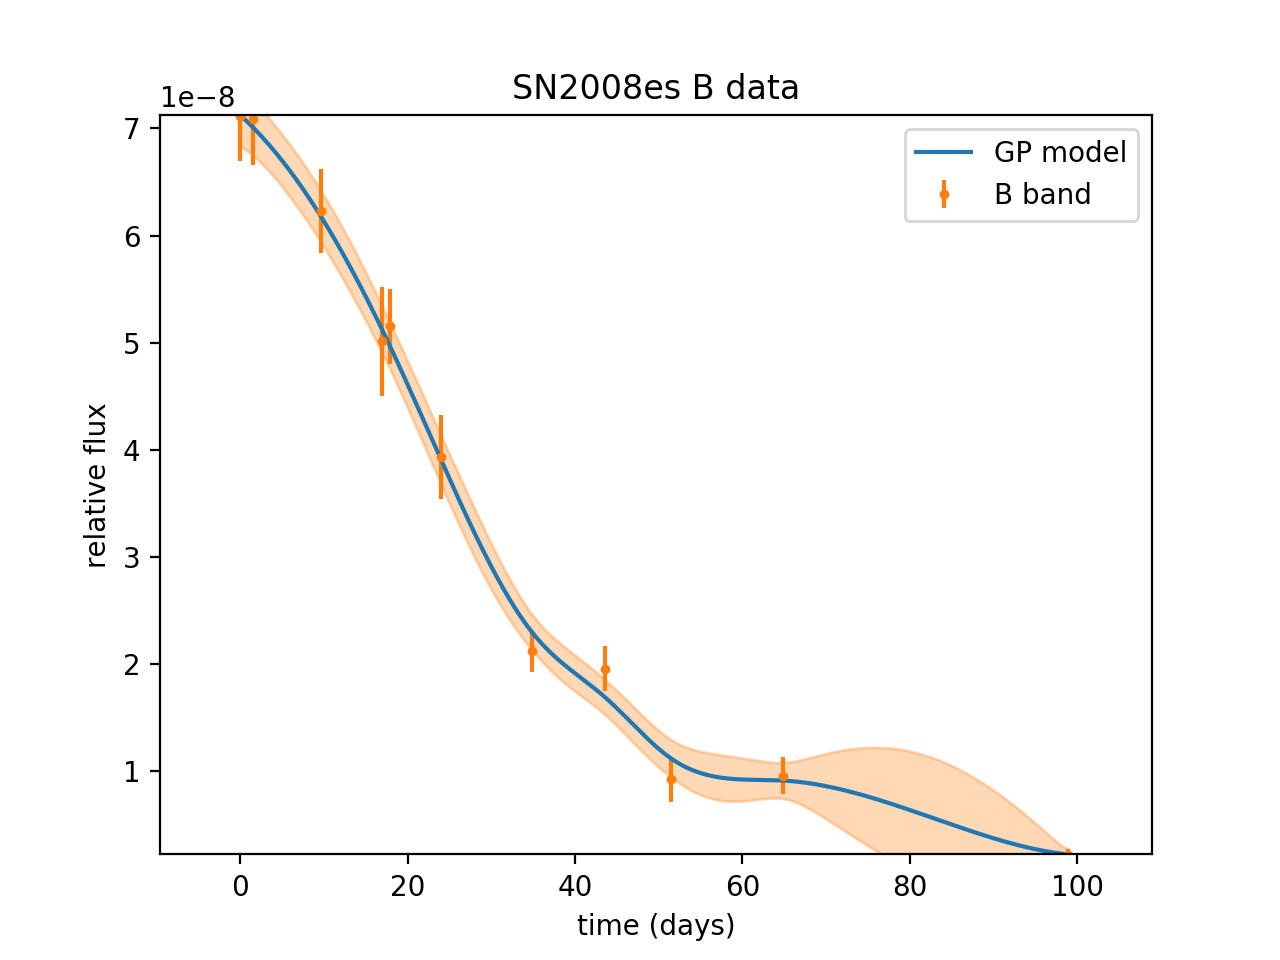

10.412150585062058

In [59]:
#Matern_Kernel fit
plt.figure()
SN2008es.Lightcurves['B_2'].Gaussian_process(Matern_Kernel)

<IPython.core.display.Javascript object>


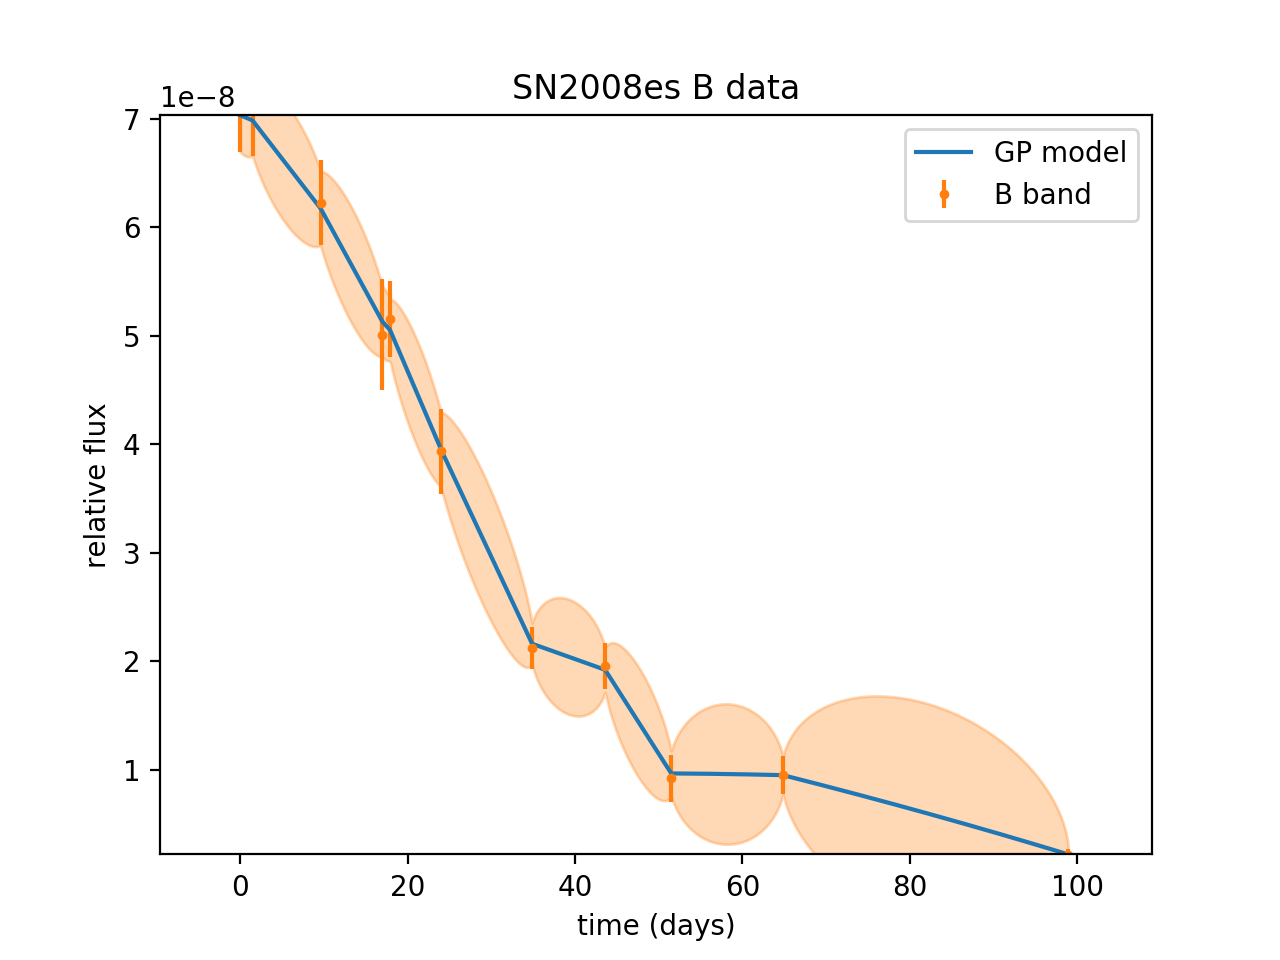

8.1946123570333249

In [60]:
plt.figure()
SN2008es.Lightcurves['B_2'].Gaussian_process(Real_Kernel)

<IPython.core.display.Javascript object>


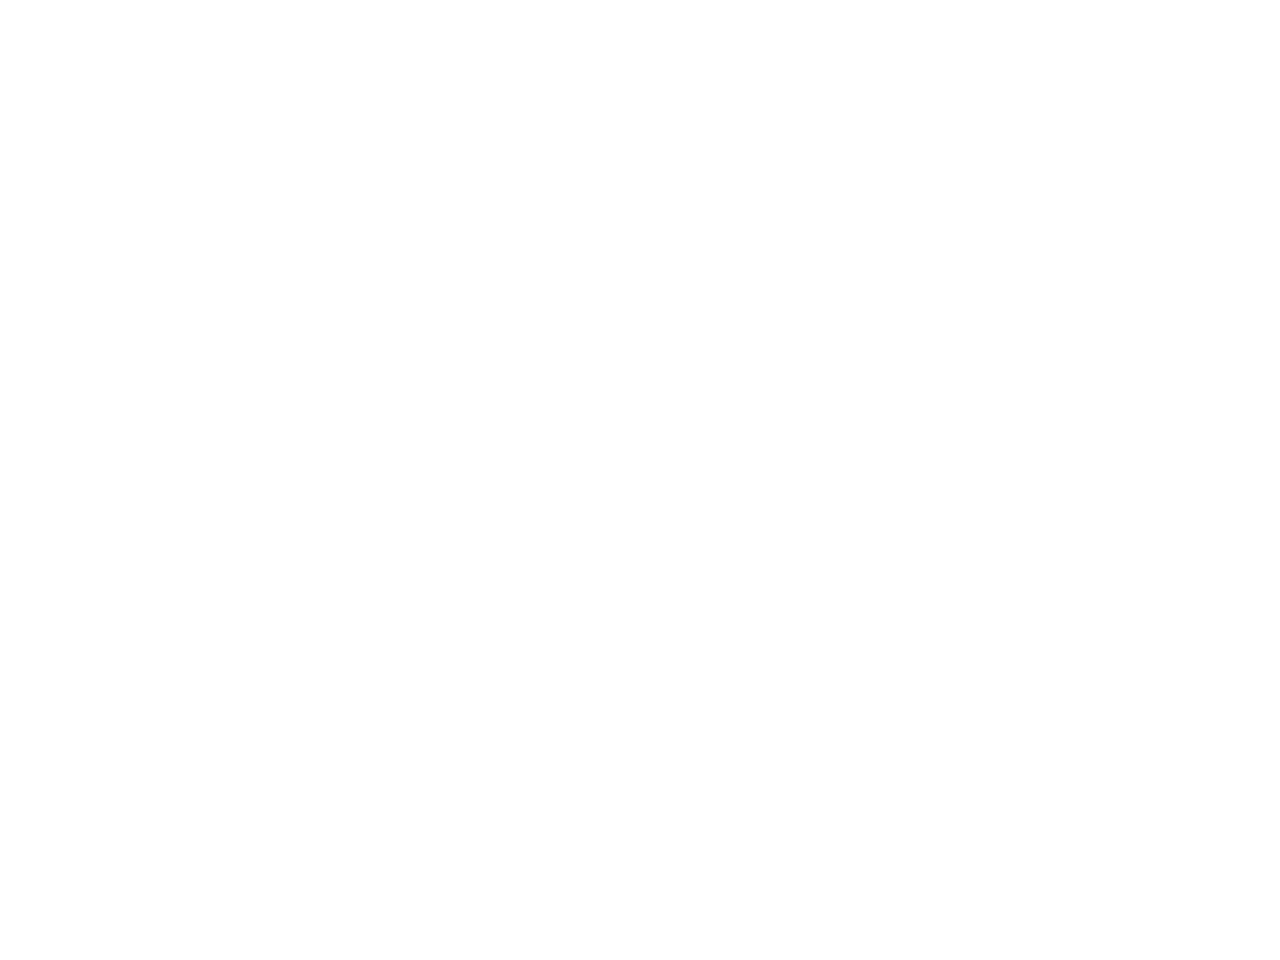

1.7368095546096145

In [61]:
plt.figure()
SN2008es.Lightcurves['B_2'].Kapernka_fit_plot()

<IPython.core.display.Javascript object>


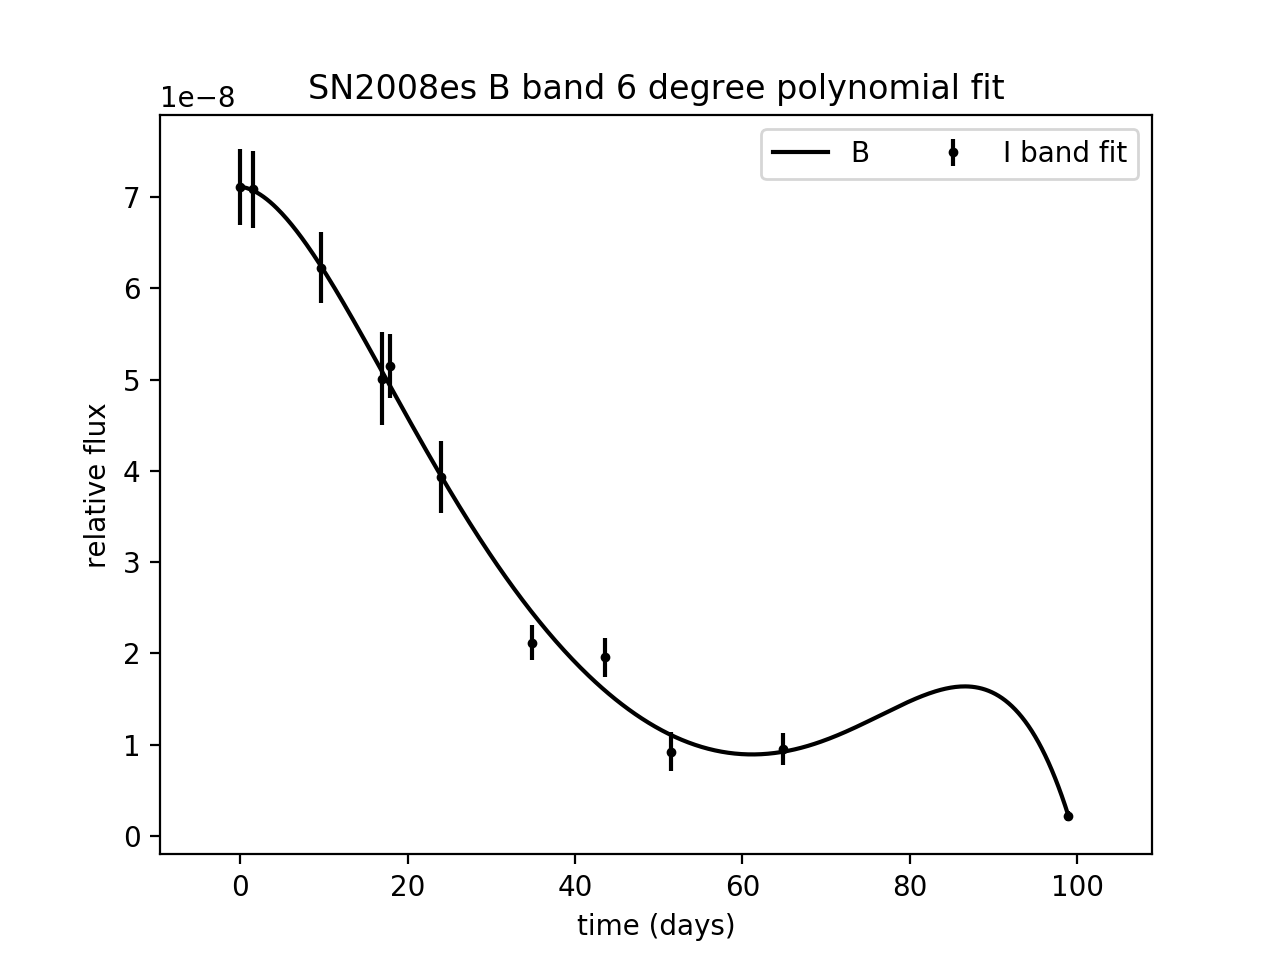

1604.2742933956702

In [15]:
plt.figure()
SN2008es.Lightcurves['B_2'].polynomial_fit_plot(6)

<IPython.core.display.Javascript object>


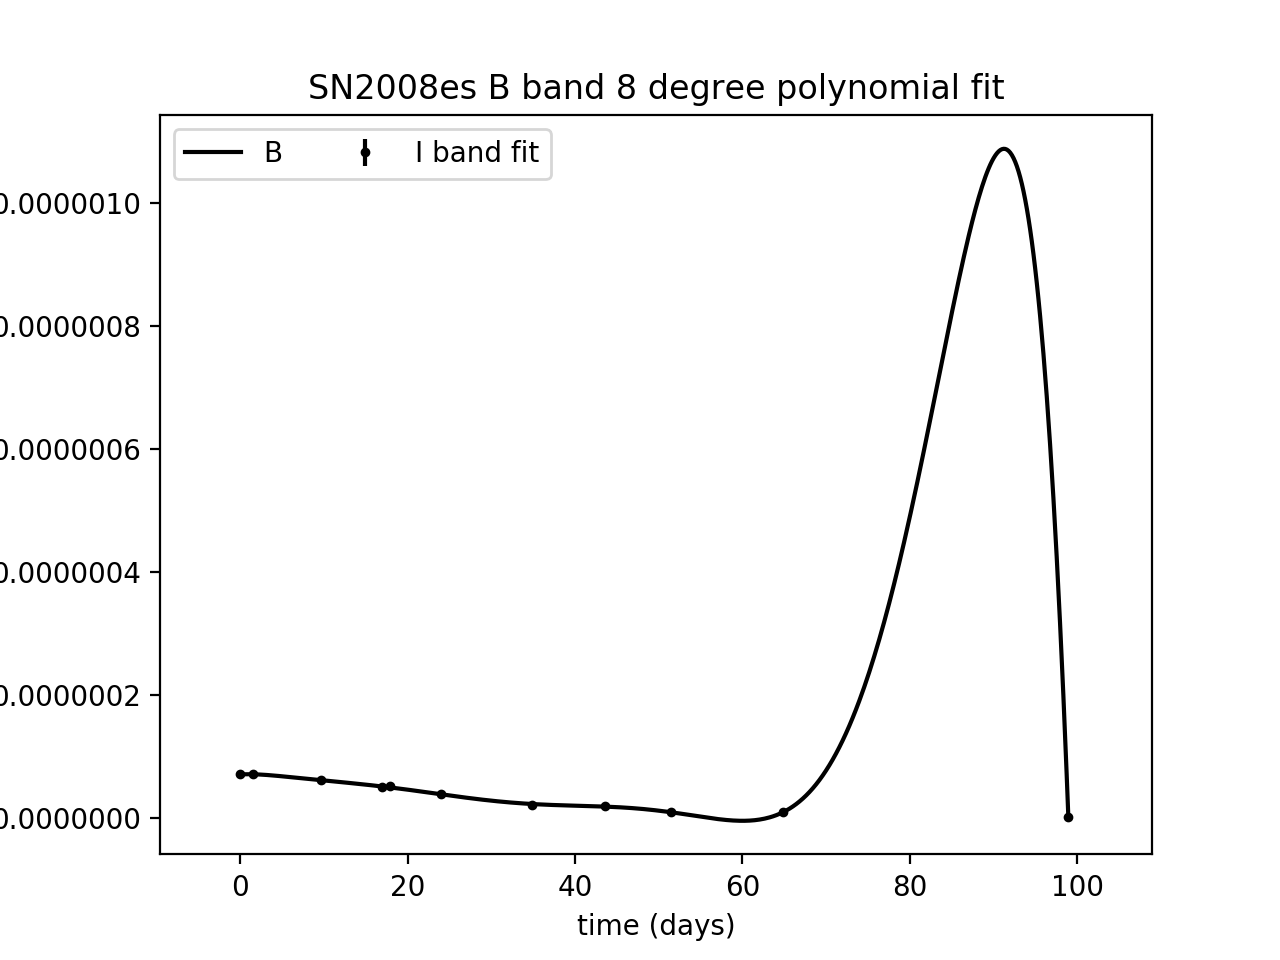

55828.308501091487

In [16]:
plt.figure()
SN2008es.Lightcurves['B_2'].polynomial_fit_plot(8)

In [17]:
SN2008es.Lightcurves['B_2'].Rchi2

{'GP': 8.1946324133189687,
 'Kapernka': 1.7368095546096145,
 'polynomial_6': 1604.2742933956702,
 'polynomial_8': 55828.308501091487}

# Supernovae SN2009ip

In [62]:
#create new supernovae object and load meta and Lightcurve data
SN2009ip = deserialize("../../../OSC_data/pickled_data/SN2009ip.pickle")

<IPython.core.display.Javascript object>


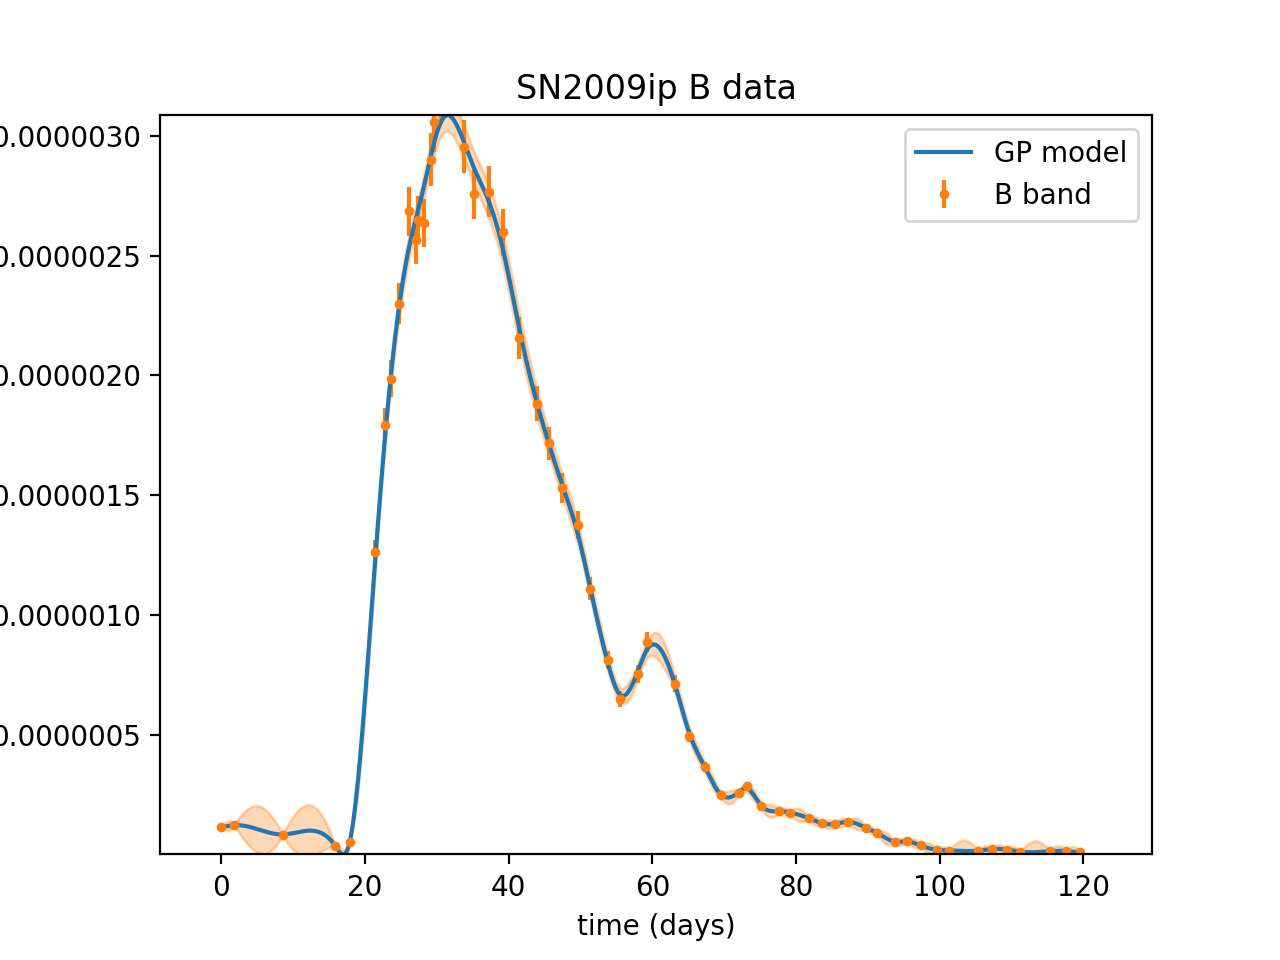

12.957295430022672

In [63]:
plt.figure()
SN2009ip.Lightcurves['B_7'].Gaussian_process(Matern_Kernel)

<IPython.core.display.Javascript object>


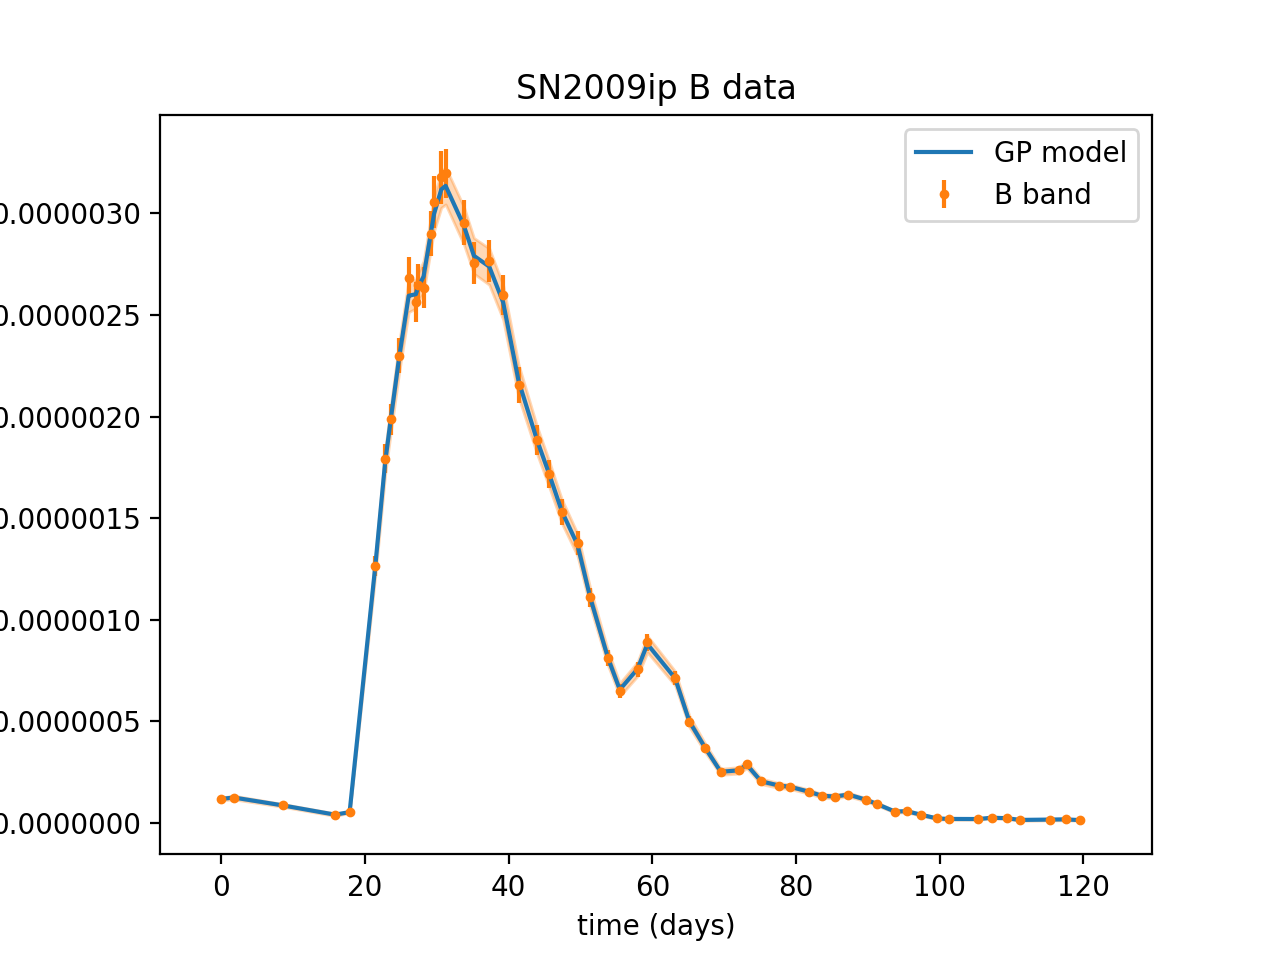

15.914498293038289

In [20]:
plt.figure()
SN2009ip.Lightcurves['B_7'].Gaussian_process(Real_Kernel)

<IPython.core.display.Javascript object>


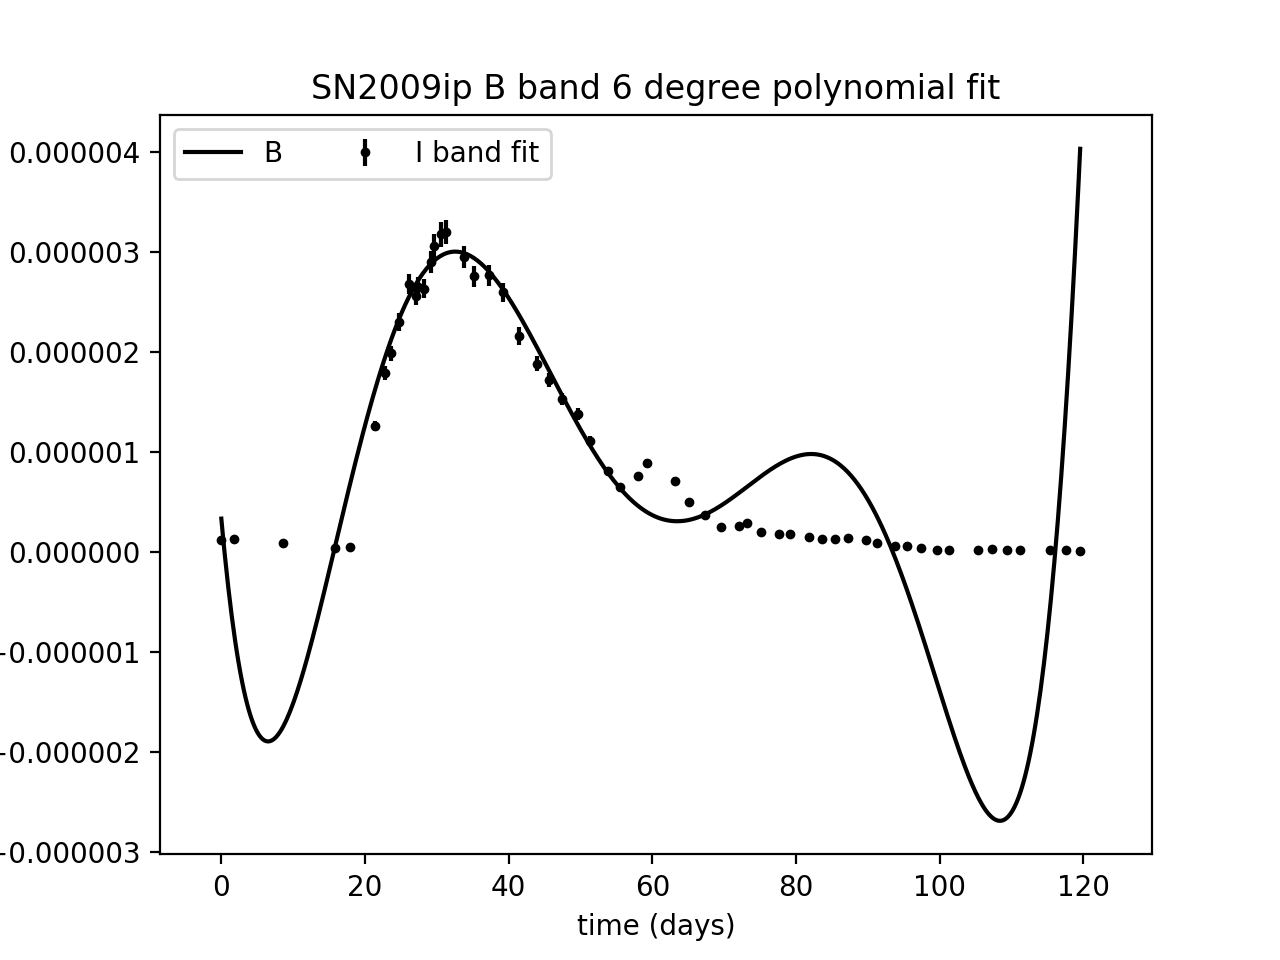

350.50405090098383

In [21]:
plt.figure()
SN2009ip.Lightcurves['B_7'].polynomial_fit_plot(6)

<IPython.core.display.Javascript object>


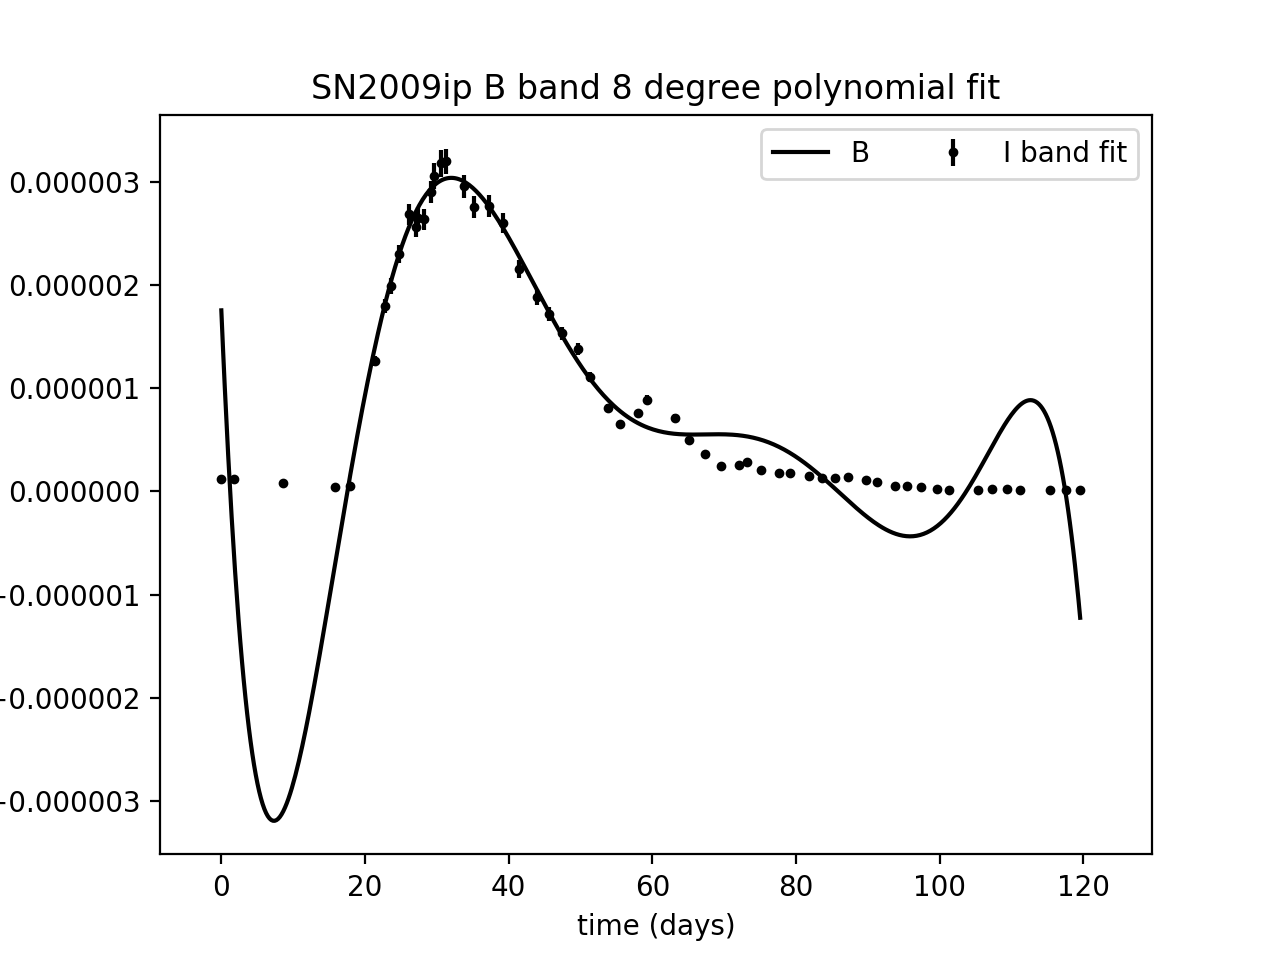

168.30276544907997

In [22]:
plt.figure()
SN2009ip.Lightcurves['B_7'].polynomial_fit_plot(8)

In [33]:
SN2009ip.Lightcurves['B_7'].Rchi2

{'GP': 15.914498293038289,
 'polynomial_6': 350.50405090098383,
 'polynomial_8': 168.30276544907997}

# Supernovae SN1999em


In [19]:
#create new supernovae object and load meta and Lightcurve data
SN1999em = deserialize("../../../OSC_data/pickled_data/SN1999em.pickle")

<IPython.core.display.Javascript object>


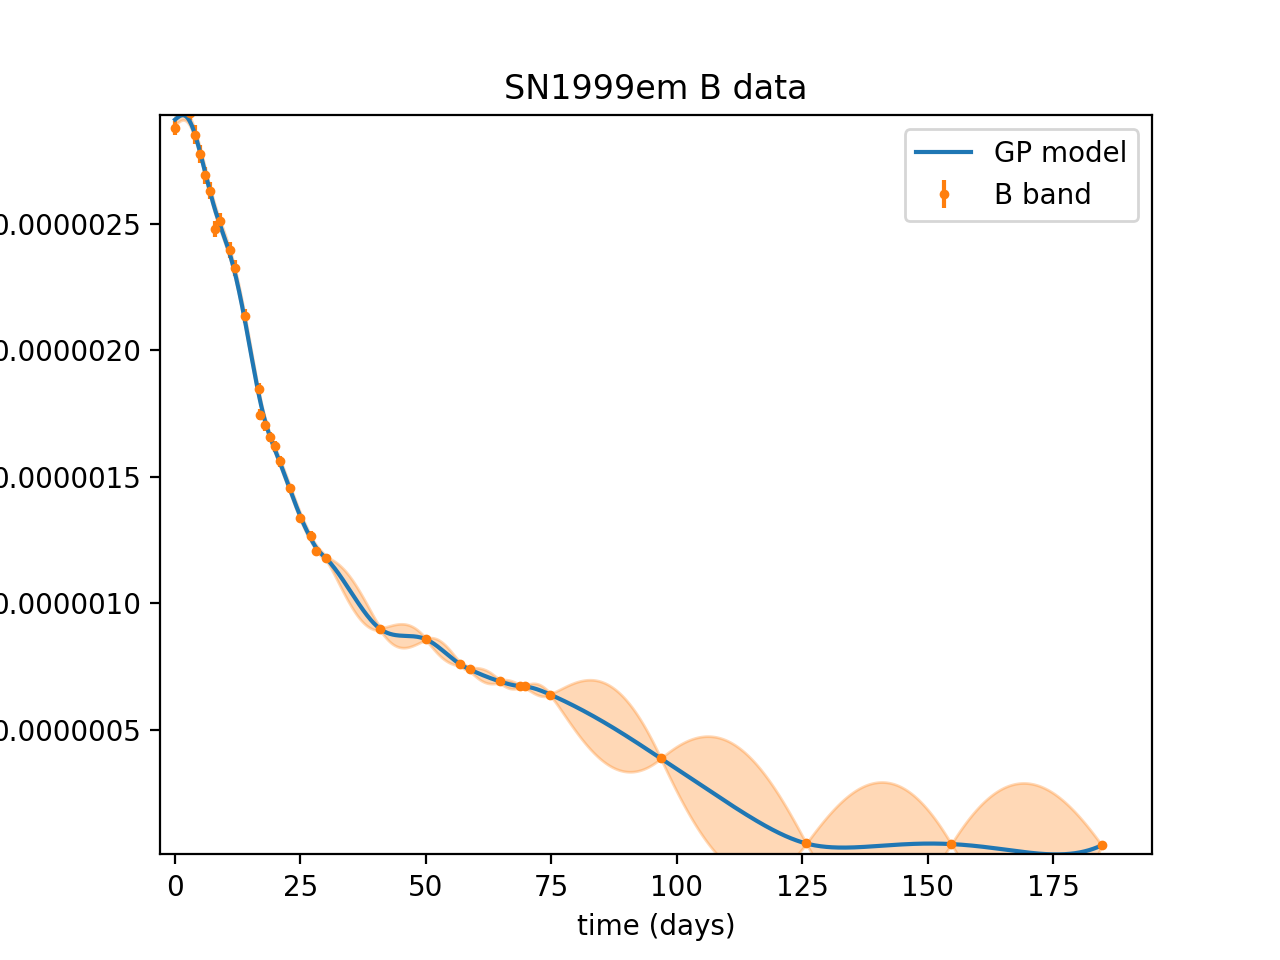

147.05504996663319

In [20]:
plt.figure()
SN1999em.Lightcurves['B_1'].Gaussian_process(Matern_Kernel)

<IPython.core.display.Javascript object>


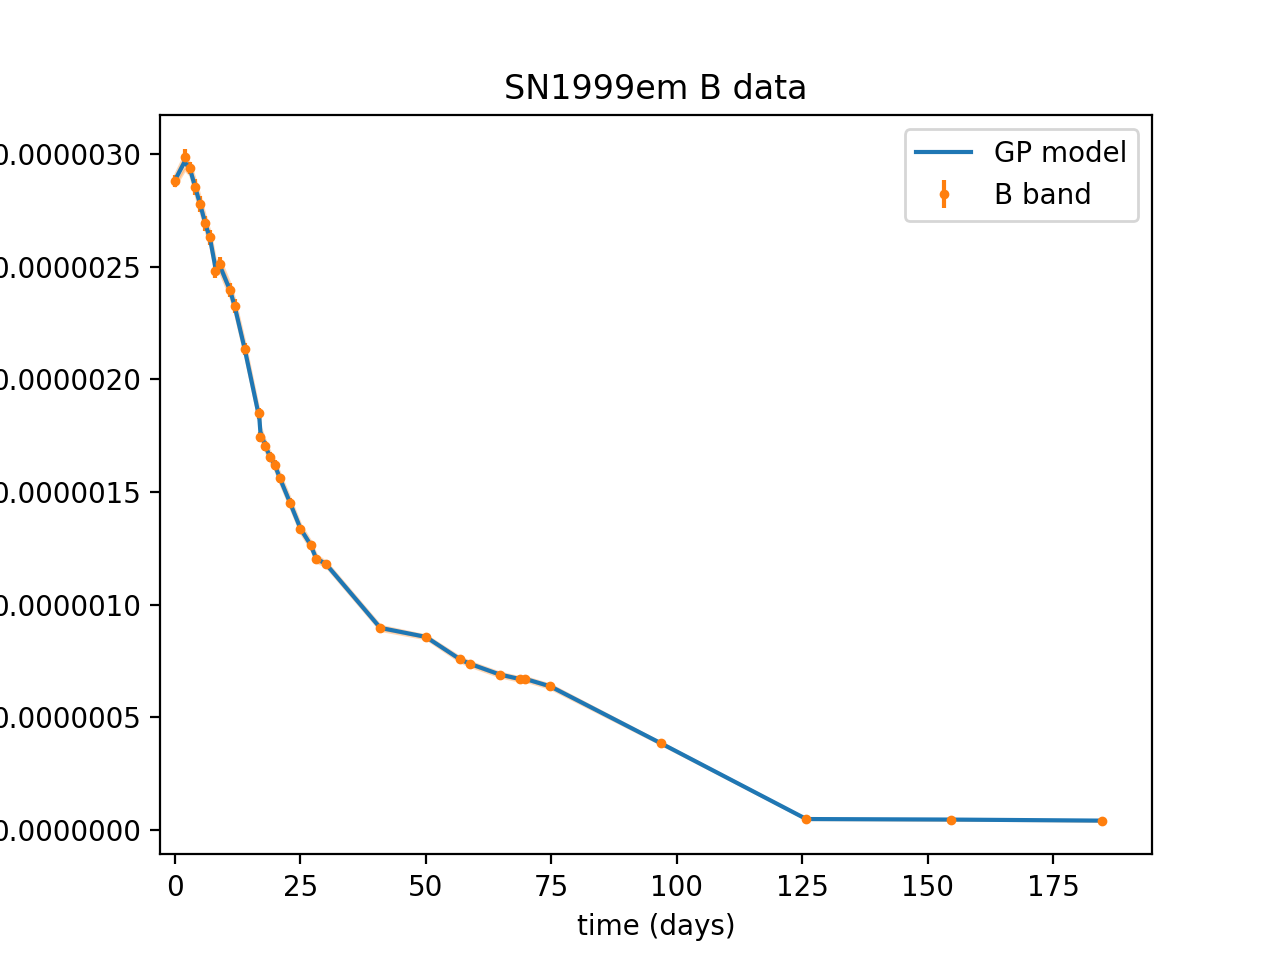

35.154826700832565

In [26]:
plt.figure()
SN1999em.Lightcurves['B_1'].Gaussian_process(Real_Kernel)

<IPython.core.display.Javascript object>


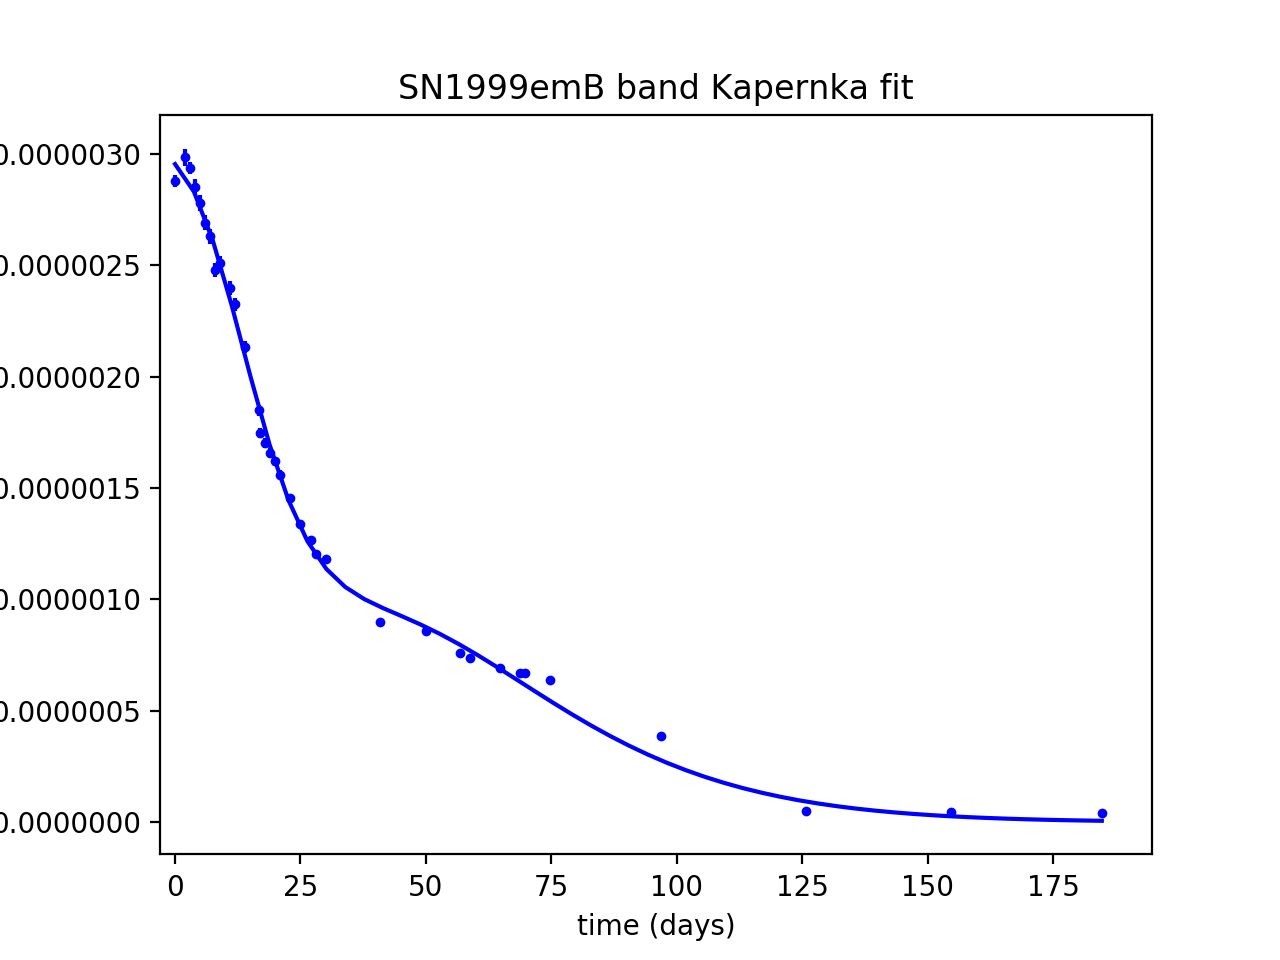

25.955431298979633

In [27]:
plt.figure()
SN1999em.Lightcurves['B_1'].Kapernka_fit_plot()

<IPython.core.display.Javascript object>


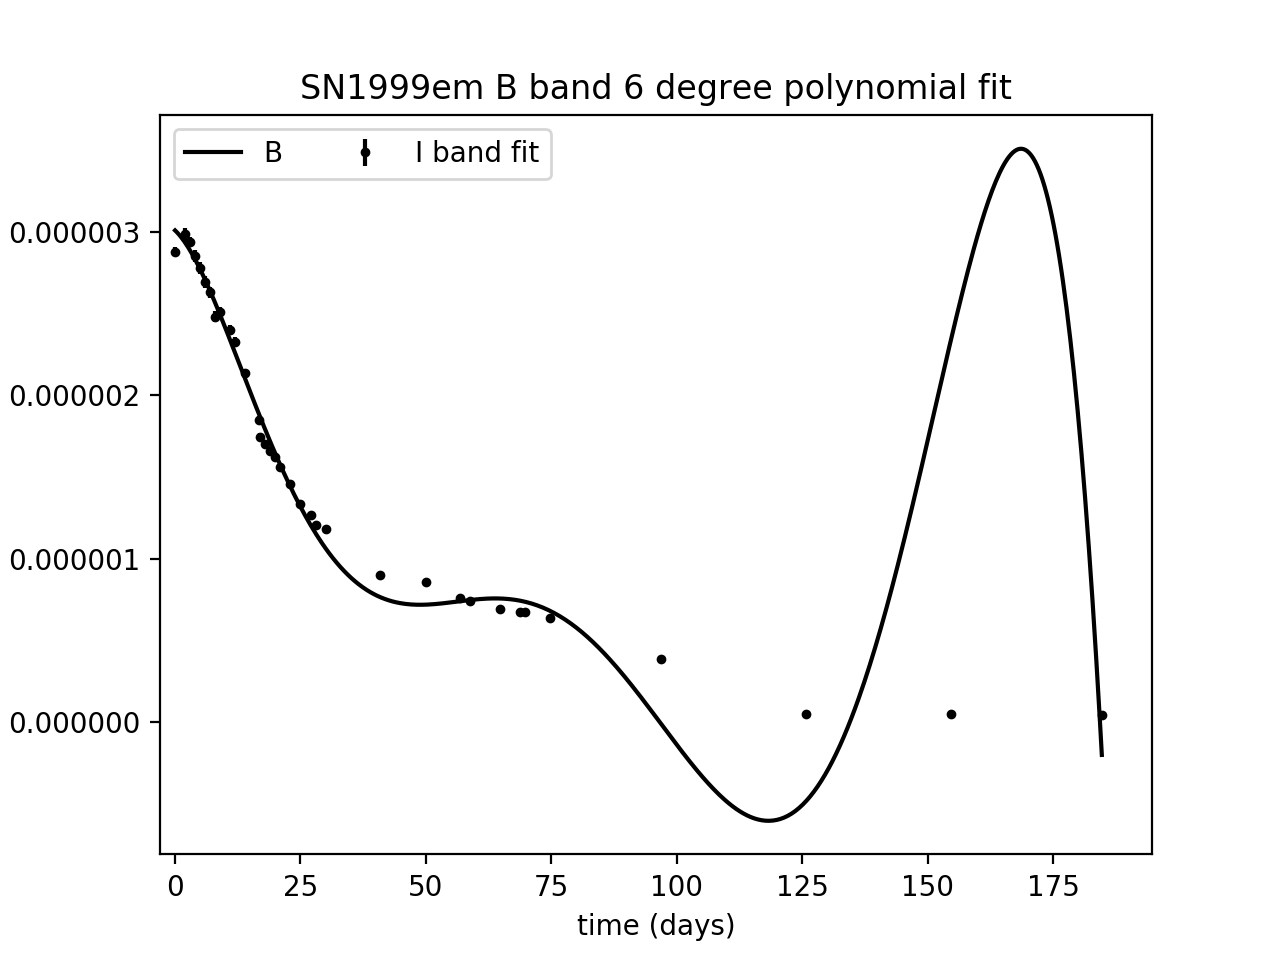

12958.730072279166

In [28]:
plt.figure()
SN1999em.Lightcurves['B_1'].polynomial_fit_plot(6)

<IPython.core.display.Javascript object>


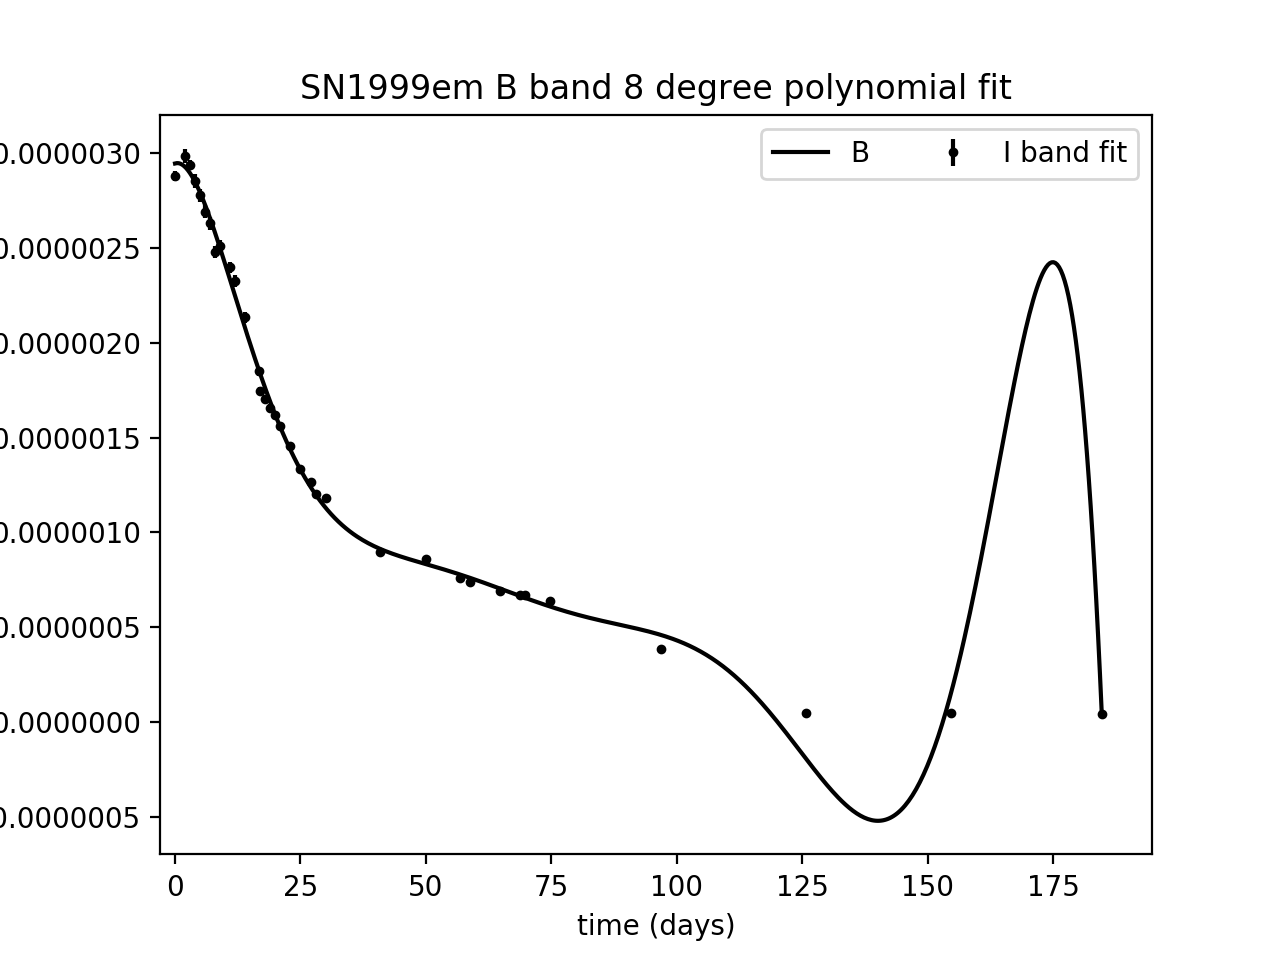

15987.022116534446

In [22]:
plt.figure()
SN1999em.Lightcurves['B_1'].polynomial_fit_plot(8)

In [23]:
SN1999em.Lightcurves['B_1'].Rchi2

{'GP': 147.05504996663319, 'polynomial_8': 15987.022116534446}

In [7]:
SNSDF0806 = deserialize("../../../OSC_data/pickled_data/SNSDF0806-48.pickle")

In [8]:
SNSDF0806.Lightcurves.keys()

AttributeError: Supernovae instance has no attribute 'Lightcurves'